<a href="https://colab.research.google.com/github/tomer-erez/DL_workshop_audio_classification/blob/main/Final_proj_Emotion_detection_team1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Emotion Detection From Audio - Final Project Deep Learning

Tomer Erez <br>
Shahar Dvir <br>
Tal Sadot <br>
Gal Mishan <br>

# Importing the dataset

In [ ]:
!wget -O kaggle.json https://raw.githubusercontent.com/tomer-erez/DL_workshop_audio_classification/main/kaggle.json

--2024-03-31 07:31:26--  https://raw.githubusercontent.com/tomer-erez/DL_workshop_audio_classification/main/kaggle.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 65 [text/plain]
Saving to: ‘kaggle.json’

kaggle.json         100%[===================>]      65  --.-KB/s    in 0s      

2024-03-31 07:31:26 (4.49 MB/s) - ‘kaggle.json’ saved [65/65]



In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle

In [ ]:
!cp /content/kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d uldisvalainis/audio-emotions

100% 1.12G/1.12G [00:16<00:00, 95.4MB/s]
100% 1.12G/1.12G [00:16<00:00, 74.9MB/s]


In [ ]:
!unzip -q audio-emotions.zip -d audio-emotions

## Data Exploration 🔍

count emotions, the data is balanced other than surprised with 75% less of other emotions

In [ ]:
emotions_path="/content/audio-emotions/Emotions"
!ls -d /content/audio-emotions/Emotions/* | xargs -n 1 basename | xargs -I {} sh -c 'echo -n "{}: "; ls "/content/audio-emotions/Emotions/{}" | wc -l'

Angry: 2167
Disgusted: 1863
Fearful: 2047
Happy: 2167
Neutral: 1795
Sad: 2167
Suprised: 592


files size in megabytes

In [ ]:
!ls -d /content/audio-emotions/Emotions/* | xargs -n 1 basename | xargs -I {} sh -c 'echo -n "{}: "; du -sh "/content/audio-emotions/Emotions/{}" | cut -f1'

Angry: 334M
Disgusted: 237M
Fearful: 286M
Happy: 330M
Neutral: 240M
Sad: 355M
Suprised: 110M


lets play some emotions

In [ ]:
import os
from IPython.display import Audio

# Iterate through each subfolder
for subfolder in os.listdir(emotions_path):
  subfolder_path = os.path.join(emotions_path, subfolder)

  # Check if it is a directory
  if os.path.isdir(subfolder_path):
    # Get the first file in the subfolder
    first_file = os.listdir(subfolder_path)[0]

    # Check if it is a wav file
    if first_file.endswith(".wav"):
      # Get the full path to the file
      file_path = os.path.join(subfolder_path, first_file)

      # Play the file
      print(subfolder_path.split('/')[-1])
      display(Audio(file_path))
      print('\n')

Suprised




Fearful




Happy




Disgusted




Sad




Neutral




Angry


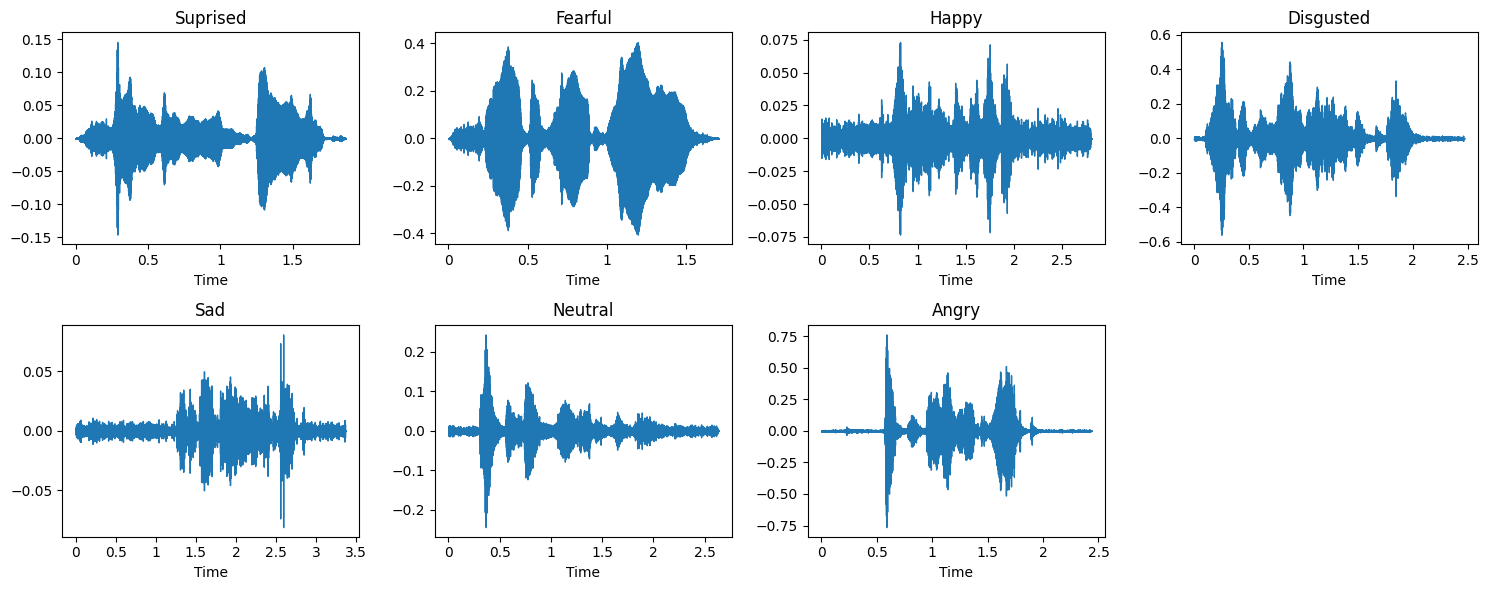

In [ ]:
import matplotlib.pyplot as plt
import librosa
import librosa.display

emotions = os.listdir(emotions_path)

plt.figure(figsize=(15, 6))
for i, emotion in enumerate(emotions):
    # Get the path to the folder containing audio files for the current emotion
    emotion_dir = os.path.join(emotions_path, emotion)
    filename = os.listdir(emotion_dir)[1]
    # Load the audio file using librosa
    audio_path = os.path.join(emotion_dir, filename)
    # Load the audio file
    y, sr = librosa.load(audio_path)

    plt.subplot(2, 4, i+1)
    # Plot the waveform
    librosa.display.waveshow(y, sr=sr)
    plt.title(emotion)

plt.tight_layout()
plt.show()

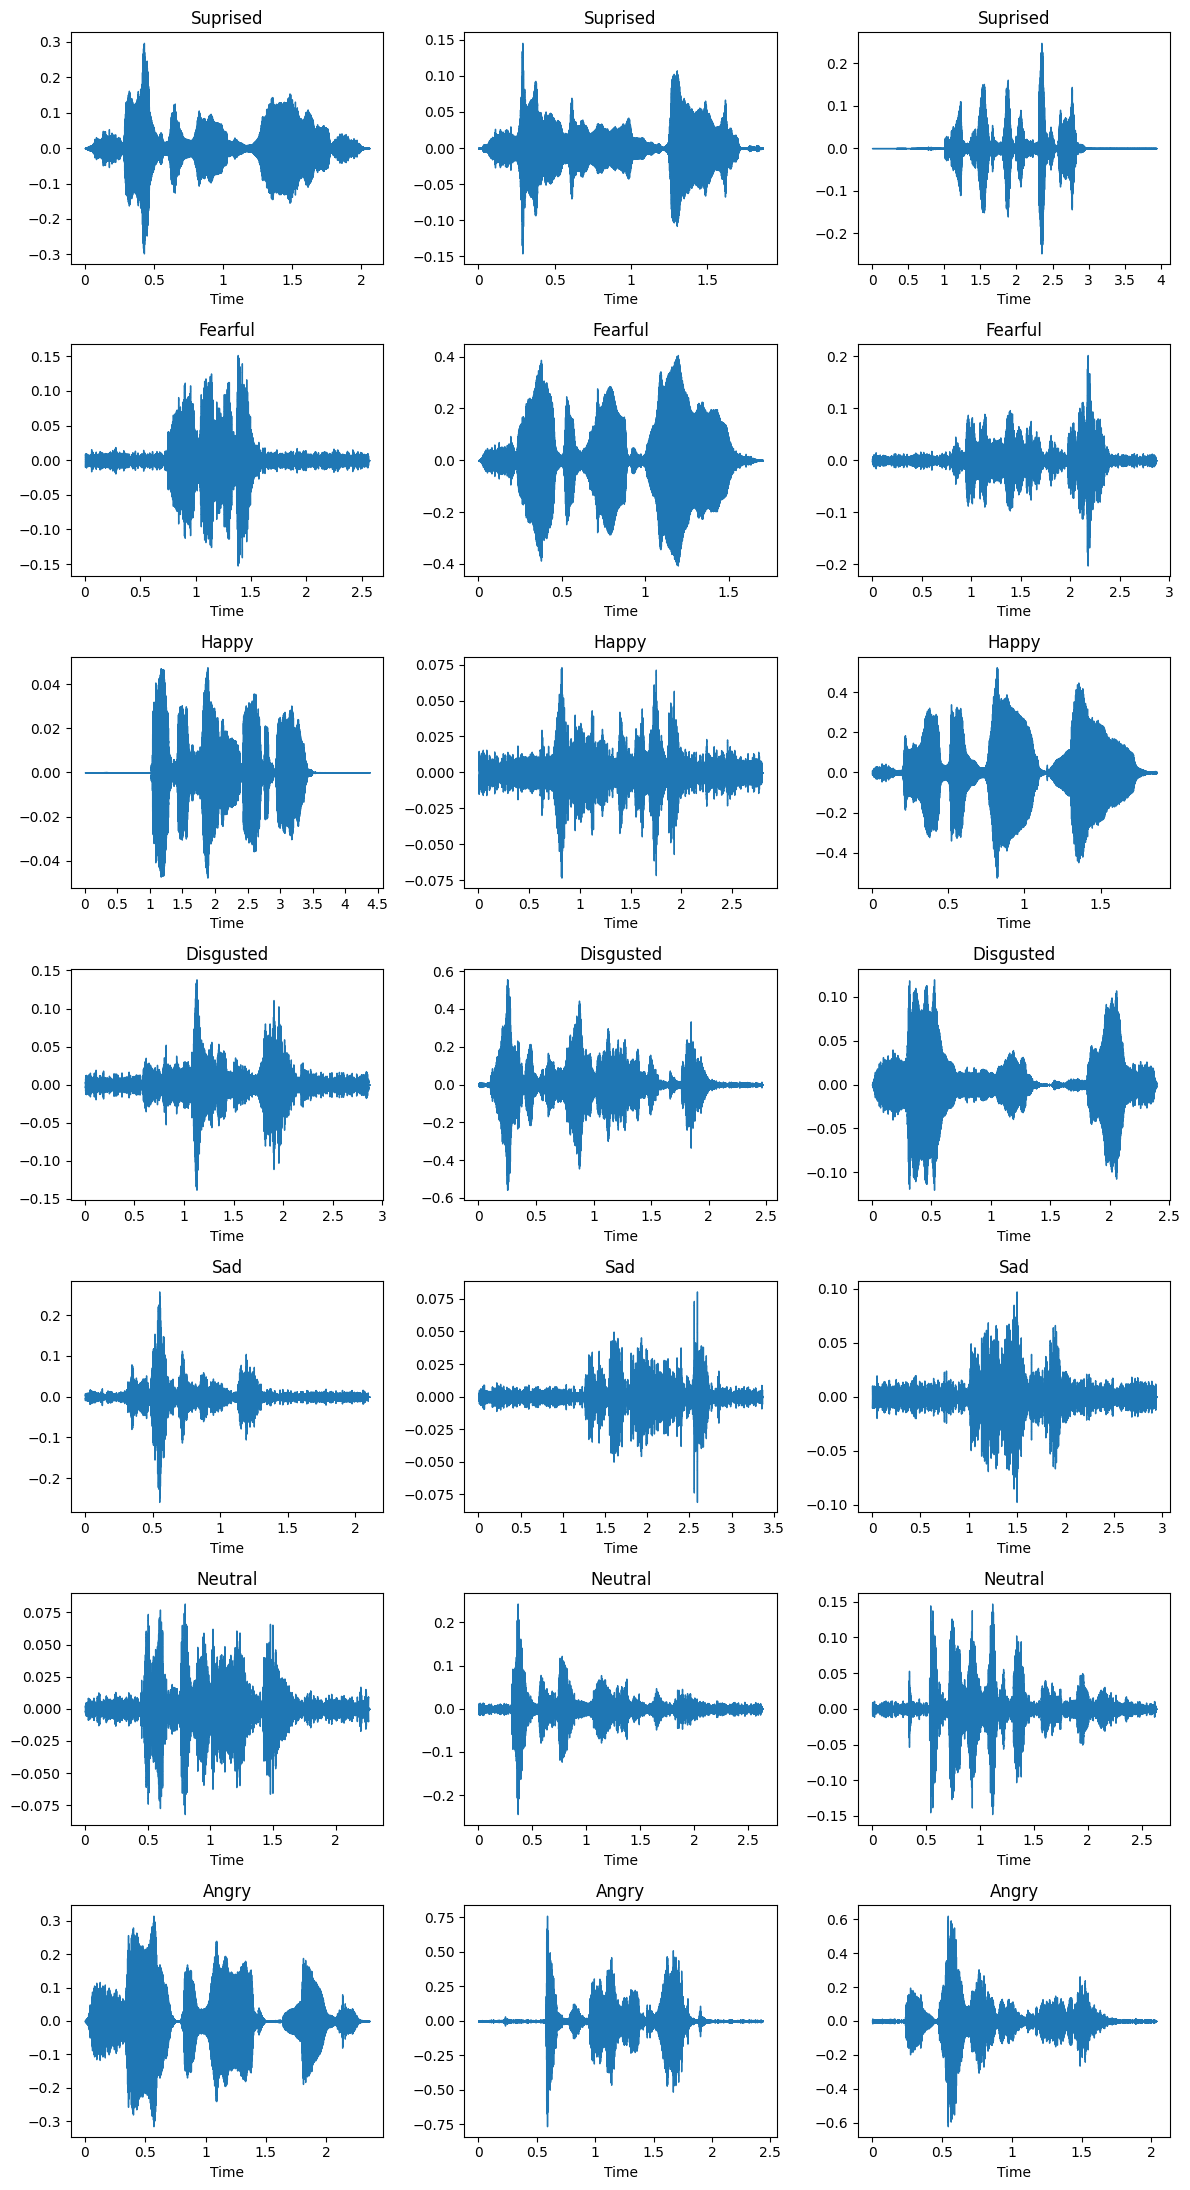

51.14901614189148 seconds


In [ ]:
import os
import matplotlib.pyplot as plt
import librosa
import librosa.display
import time
start = time.time()

emotions = os.listdir(emotions_path)

# Adjust the figure size according to your preference
plt.figure(figsize=(12, 22))

# Loop through each emotion
for i, emotion in enumerate(emotions):
    emotion_dir = os.path.join(emotions_path, emotion)

    # Loop through each audio file in the emotion directory
    for j in range(3):
        # Get the path to the current audio file
        filename = os.listdir(emotion_dir)[j]
        audio_path = os.path.join(emotion_dir, filename)

        # Load the audio file using librosa
        y, sr = librosa.load(audio_path)

        # Plot the waveform in the corresponding subplot
        plt.subplot(len(emotions), 3, i*3 + j + 1)
        librosa.display.waveshow(y, sr=sr)
        plt.title(emotion)
        plt.tight_layout()

# Display the entire plot
plt.show()
end = time.time()
print(f'{end-start} seconds') # about 50


lengths of recordings

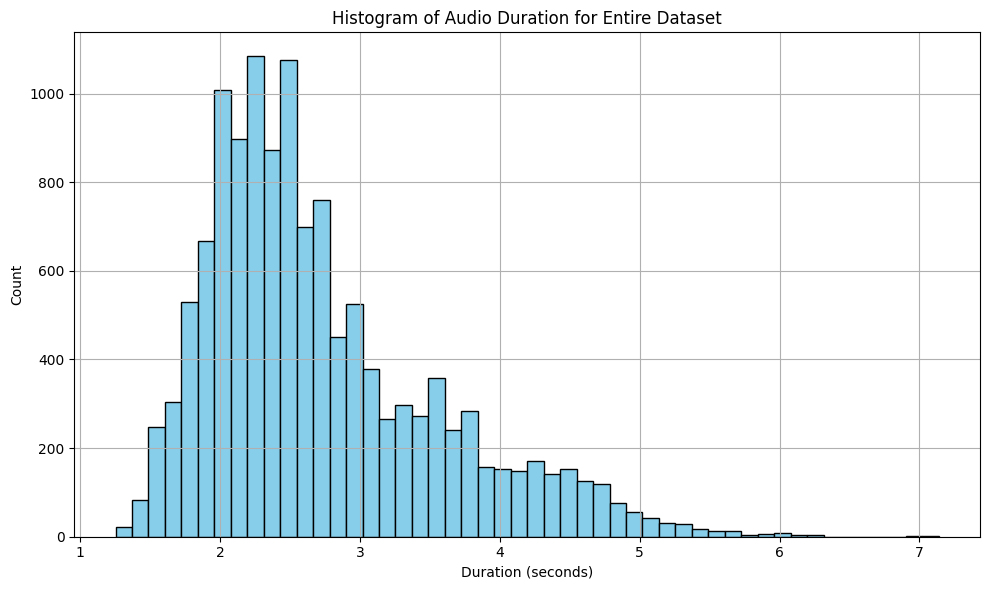

Time taken: 35.35531234741211 seconds


In [ ]:
import os
import librosa
import matplotlib.pyplot as plt

start = time.time()

# List to store durations of all audio files
all_durations = []

# Loop through each emotion
for root, dirs, files in os.walk(emotions_path):
    for file in files:
        if file.endswith(".wav"):
            audio_path = os.path.join(root, file)
            # Get the duration of the audio file using librosa
            y, sr = librosa.load(audio_path)
            duration = librosa.get_duration(y=y, sr=sr)
            all_durations.append(duration)

# Plot the histogram of all durations
plt.figure(figsize=(10, 6))
plt.hist(all_durations, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Duration (seconds)')
plt.ylabel('Count')
plt.title('Histogram of Audio Duration for Entire Dataset')
plt.grid(True)
plt.tight_layout()
plt.show()

end = time.time()
print(f'Time taken: {end - start} seconds')


hard to learn anything from the audio wave. lets trim the files and plot histograms.

cutting silent parts

In [ ]:
!pip -q install pydub

In [ ]:
import os
import time
import multiprocessing
from pydub import AudioSegment
from pydub.silence import split_on_silence

def remove_silence(audio_file,out_path):
    sound = AudioSegment.from_file(audio_file)
    # Split on silence
    non_silent_chunks = split_on_silence(sound, min_silence_len=30, silence_thresh=-1, keep_silence=3)
    print(non_silent_chunks)
    if len(non_silent_chunks) == 0:
      return
    # Concatenate non-silent chunks
    result = non_silent_chunks[0]
    for chunk in non_silent_chunks[1:]:
        result += chunk

    # Save the result
    result.export(out_path, format="wav")

def process_emotion(emotion):
    emotion_path = os.path.join(emotions_path, emotion)
    for root, _, files in os.walk(emotion_path):
        for file in files:
            if file.endswith(".wav"):
                audio_file = os.path.join(root, file)
                remove_silence(audio_file,audio_file)


In [ ]:
remove_silence("/content/audio-emotions/Emotions/Suprised/03-01-08-01-01-01-01.wav",'/content/to_delete.wav')
display(Audio("/content/audio-emotions/Emotions/Suprised/03-01-08-01-01-01-01.wav"))
display(Audio('/content/to_delete.wav'))


# models

## spectogram cnn with noise addition

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical

# Constants
emotions_path = "/content/audio-emotions/Emotions"
emotion_labels = ["Angry", "Disgust", "Fearful", "Happy", "Neutral", "Sad", "Surprised"]
num_emotions = len(emotion_labels)
sample_rate = 22050
n_fft = 2048  # FFT window size
hop_length = 512  # Hop length for STFT
num_mels = 128  # Number of Mel bands
max_pad_len = 174  # Adjust according to your maximum audio length or desired STFT size

# Function to create STFT spectrograms
def create_stft_spectrogram(audio_path):
    audio, _ = librosa.load(audio_path, sr=sample_rate)
    stft = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length)
    stft_mag = np.abs(stft)
    mel_spec = librosa.feature.melspectrogram(S=stft_mag, sr=sample_rate, n_mels=num_mels)
    log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
    pad_width = max_pad_len - log_mel_spec.shape[1]
    log_mel_spec = np.pad(log_mel_spec, pad_width=((0, 0), (0, pad_width)), mode='constant')
    return log_mel_spec

# Load data and create STFT spectrograms
data = []
labels = []

for i, emotion in enumerate(emotion_labels):
    emotion_dir = os.path.join(emotions_path, emotion)
    for filename in os.listdir(emotion_dir):
        audio_path = os.path.join(emotion_dir, filename)
        spectrogram = create_stft_spectrogram(audio_path)
        data.append(spectrogram)
        labels.append(i)

# Convert lists to numpy arrays
data = np.array(data)
labels = np.array(labels)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Reshape data for CNN input (add channel dimension)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, num_classes=num_emotions)
y_test = to_categorical(y_test, num_classes=num_emotions)

# Build the CNN model
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(num_mels, max_pad_len, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_emotions, activation='softmax')
])

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32)

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_acc)

# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()


## markov chains hmm

In [ ]:
import os
import numpy as np
import librosa
from hmmlearn import hmm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Constants
emotions_path = "/content/audio-emotions/Emotions"
emotion_labels = ["Angry", "Disgust", "Fearful", "Happy", "Neutral", "Sad", "Surprised"]
num_emotions = len(emotion_labels)
sample_rate = 22050
num_mfcc = 13  # Number of MFCC coefficients
n_components = 3  # Number of HMM states

# Function to extract MFCC features from audio files
def extract_mfcc(audio_path):
    audio, _ = librosa.load(audio_path, sr=sample_rate)
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=num_mfcc)
    return mfccs.T  # Transpose to have time along the rows

# Load data and extract MFCC features
X = []
y = []

for i, emotion in enumerate(emotion_labels):
    emotion_dir = os.path.join(emotions_path, emotion)
    for filename in os.listdir(emotion_dir):
        audio_path = os.path.join(emotion_dir, filename)
        mfccs = extract_mfcc(audio_path)
        X.append(mfccs)
        y.append(i)

# Convert lists to numpy arrays
X = np.concatenate(X)
y = np.array(y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Hidden Markov Model
models = [hmm.GaussianHMM(n_components=n_components, covariance_type='diag', n_iter=100) for _ in range(num_emotions)]

for i, model in enumerate(models):
    X_emotion = X_train[y_train == i]
    lengths = [len(seq) for seq in X_emotion]
    X_emotion_concatenated = np.concatenate(X_emotion)
    model.fit(X_emotion_concatenated, lengths=lengths)

# Predict labels for testing data
y_pred = [np.argmax([model.score(seq) for model in models]) for seq in X_test]

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


# evaluation